

## Garbage Classifier: A Machine Learning Approach to Waste Management

### By Syed Mohammed

Garbage classification is a crucial task in reducing waste and managing resources effectively, which also plays a critical role in solving the water pollution issue. Our project utilizes **PyTorch** and **ResNet50** to develop a garbage classification model capable of identifying various types of waste.

The model is trained to recognize six categories of garbage, namely **cardboard, glass, metal, paper, plastic**, and **general trash**. By fine-tuning the pre-trained **ResNet50** architecture with a **learning rate** of **0.00005**, we have improved the models accuracy.

The implications of our garbage classification model are significant, particularly in waste management. It can help reduce the amount of waste that ends up on beaches, promote recycling, and conserve natural resources. By classifying waste effectively, we can work towards a cleaner and more sustainable environment, ultimately helping to solve the water pollution issue.



# Importing Libraries


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import numpy as np
import random
import os


# Loading the Dataset


In [4]:
directory  = 'C:/Users/legen/Eco_Bins/garbage_classification/all_classes/'

garbage_classes = os.listdir(directory)
print(garbage_classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']



# Transforming the Dataset 

Transformations can perform various operations such as resizing, cropping, normalizing, and augmenting images. These operations help to increase the variability of the data and prevent overfitting of the model to specific data points.

In [5]:
# Importing Transforms to modify the images

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Resize all images to 224x224 pixels and converting to Tensor

transformations = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Load the dataset and apply the transformations

dataset = ImageFolder(directory, transform = transformations)


# Testing the dataset by randomly displaying images and their labels


Label: paper (Class No: 3)


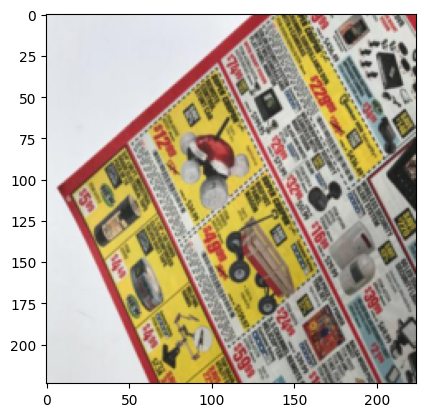

In [6]:
# Permute the dimensions of the image to fit the format of the matplotlib

def display_test(image, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))
    
# Display a random image from the dataset

image, label = dataset[random.randint(0, len(dataset))]
display_test(image, label)




# Loading Data


In [7]:
# Setting a seed for easier debugging and comparison of results

random_seed = 43
torch.manual_seed(random_seed)


# Splitting Dataset

Splitting dataset to training, validating and testing sets.


In [8]:
# Split the dataset into train, validate, and test datasets

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

from torch.utils.data.dataloader import DataLoader
batch_size = 32



# Creating the DataLoaders


In [9]:
train = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
validation = DataLoader(val_data, batch_size * 2, num_workers = 4, pin_memory = True)



# Batch Visualization


In [10]:
from torchvision.utils import make_grid

def batch_visualization(data):
    for image, labels in data:
        fig, ax = plt.subplots(figsize = (14, 14))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(image, nrow = 16).permute(1, 2, 0))
        break
    

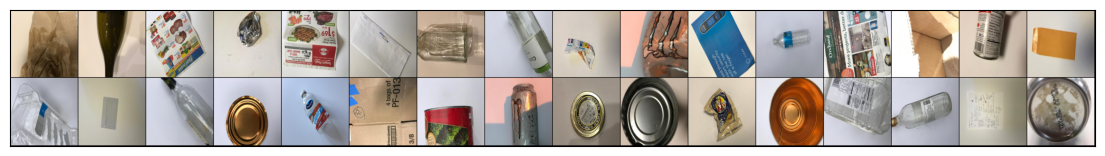

In [11]:
batch_visualization(train)


# Defining the Model

Defining the model architecture and loading the pre-trained weights. ???

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassification(nn.Module):
    
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    
    def validating(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'Validation Loss': loss.detach(), 'Validation Accuracy': acc}
    
    
    def validating_epoch_final(self, outputs):
        batch_loss = [x['Validation Loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_accuracy = [x['Validation Accuracy'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'Validation Loss': epoch_loss.item(), 'Validation Accuracy': epoch_accuracy.item()}
        
    
    
    def epoch_final(self, epoch, result):
        print("Epoch [{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}"
              .format(epoch + 1, result['Training Loss'], result['Validation Loss'], result['Validation Accuracy']))
        


# Using ResNet50 for Classification


write about resnet50 here


In [13]:
class ResNet(ImageClassification):
    def __init__(self):
        super().__init__()
        # Using Pre-Trained Model
        self.network = models.resnet50(weights = "ResNet50_Weights.DEFAULT")
        features = self.network.fc.in_features
        self.network.fc = nn.Linear(features, len(garbage_classes))
    
    def forward(self, image):
        return torch.sigmoid(self.network(image))
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                     # Generate predictions
        loss = F.cross_entropy(out, labels)    # Calculate loss
        return loss
    def epoch_final(self, epoch, result):
        print("Epoch [{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}"
              .format(epoch + 1, result['Train Loss'], result['Validation Loss'], result['Validation Accuracy']))
        
    
model = ResNet()



Testing if the model is working properly by displaying a random image and its predicted label.

In [14]:
# Porting the model to GPU
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()

# Move the model to GPU
def move_to_gpu(data, device):
    # Move Tensor to GPU
    if isinstance(data, (list, tuple)):
        return [move_to_gpu(x, device) for x in data]
    return data.to(device, non_blocking = True)

# DataLoading Class
class DataLoad():
    def __init__(self, data, device):
        self.data = data
        self.device = get_default_device()
    
    # Yields batch after moving to device
    def __iter__(self):
        for batch in self.data:
            yield move_to_gpu(batch, self.device)
    
    # Returns the length of the data
    def __len__(self):
        return len(self.data)


In [15]:
device = get_default_device()
device  

device(type='cuda')

In [16]:
train = DataLoad(train, device)
validation = DataLoad(validation, device)
move_to_gpu(model, device)



ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (


# Finally, Model Training


Defining the loss function and optimizer. Then, training the model for 10 epochs.

In [17]:
@torch.no_grad()
def evaluate(model, validator):
    model.eval()
    outputs = [model.validating(batch) for batch in validator]
    return model.validating_epoch_final(outputs)

def opt(epochs, learning_rate, model, train_loader, validator, opt_func=torch.optim.SGD):
    training_history = []
    optimizer = opt_func(model.parameters(), learning_rate)
    for epoch in range(epochs):
        
        # Training Step
        
        model.train()
        train_loss = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, validator)
        result['Train Loss'] = torch.stack(train_loss).mean().item()
        model.epoch_final(epoch, result)
        training_history.append(result)
    return training_history


In [18]:
model = move_to_gpu(ResNet(), device)


In [19]:
evaluate(model, validation)

{'Validation Loss': 1.7875317335128784,
 'Validation Accuracy': 0.19380483031272888}

In [51]:
epoch = 10
optimizer = torch.optim.Adam
learning_rate = 0.00005

model_history = opt(epoch, learning_rate, model, train, validation, optimizer)

Epoch [1], Training Loss: 1.6878, Validation Loss: 1.5076, Validation Accuracy: 0.7813
Epoch [2], Training Loss: 1.3997, Validation Loss: 1.2835, Validation Accuracy: 0.8643
Epoch [3], Training Loss: 1.2248, Validation Loss: 1.1830, Validation Accuracy: 0.9075
Epoch [4], Training Loss: 1.1476, Validation Loss: 1.1605, Validation Accuracy: 0.9097
Epoch [5], Training Loss: 1.1054, Validation Loss: 1.1390, Validation Accuracy: 0.9212
Epoch [6], Training Loss: 1.0858, Validation Loss: 1.1446, Validation Accuracy: 0.9114
Epoch [7], Training Loss: 1.0738, Validation Loss: 1.1298, Validation Accuracy: 0.9214
Epoch [8], Training Loss: 1.0633, Validation Loss: 1.1239, Validation Accuracy: 0.9290
Epoch [9], Training Loss: 1.0603, Validation Loss: 1.1326, Validation Accuracy: 0.9075
Epoch [10], Training Loss: 1.0578, Validation Loss: 1.1271, Validation Accuracy: 0.9192


### Plotting the Accuracy vs Epochs

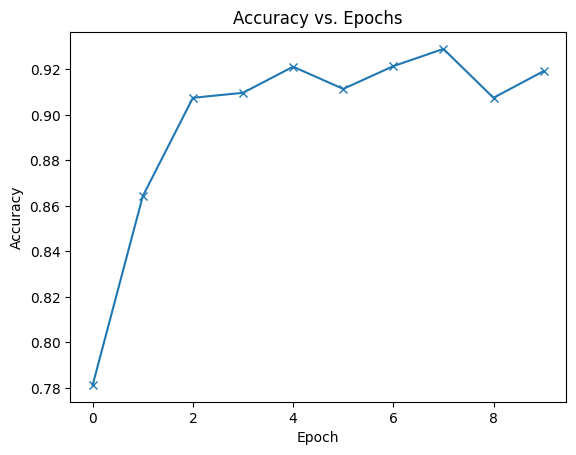

In [52]:
def plot_accuracy(model_history):
    accuracies = [x['Validation Accuracy'] for x in model_history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs')
    
plot_accuracy(model_history)

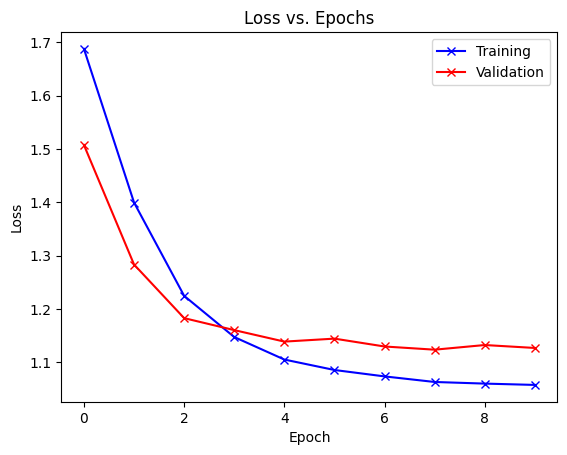

In [53]:
def plot_loss(model_history):
    train_loss = [x.get('Train Loss') for x in model_history]
    validation_loss = [x['Validation Loss'] for x in model_history]
    plt.plot(train_loss, '-bx')
    plt.plot(validation_loss, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Epochs')
    
plot_loss(model_history)

### Visualize the predictions

In [54]:
def predict(image, model):
    # Convert to a batch of 1
    xb = move_to_gpu(image.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds = torch.max(yb, dim = 1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Testing the model on the test set.


Test #1

Class: plastic , Predicted Class: plastic


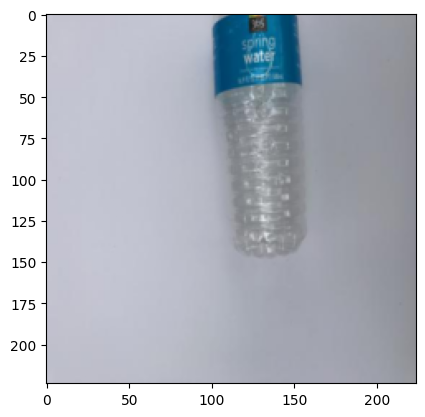

In [55]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0))
print('Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))

Test #2

Class: plastic , Predicted Class: plastic


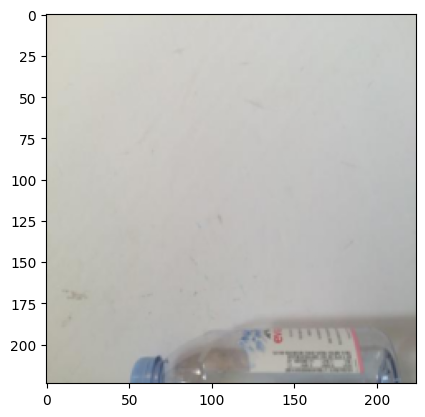

In [56]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0))
print('Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))

### Test #3

Class: paper , Predicted Class: paper


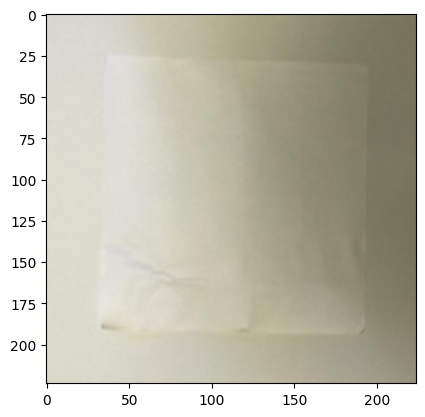

In [57]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0))
print('Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))

### Predicting on a random image


Loading the model and predicting on a random image.

In [58]:
loaded_model = model

from PIL import Image
from pathlib import Path
def predict_random(image_name):
    image = Image.open(Path('external' + '/' + image_name))
    example = transformations(image)
    plt.imshow(example.permute(1, 2, 0))
    print('Predicted Class:', predict(example, loaded_model))

Predicted Class: metal


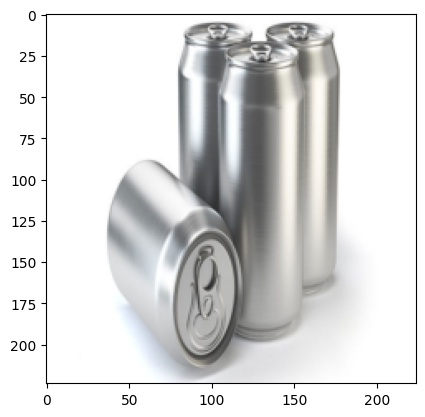

In [61]:
predict_random('cans.jpg')

Predicted Class: paper


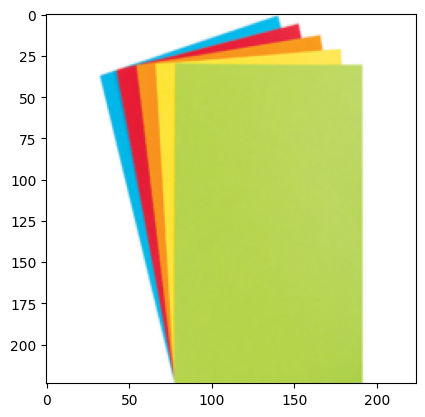

In [62]:
predict_random('cbz251.jpg')

Predicted Class: metal


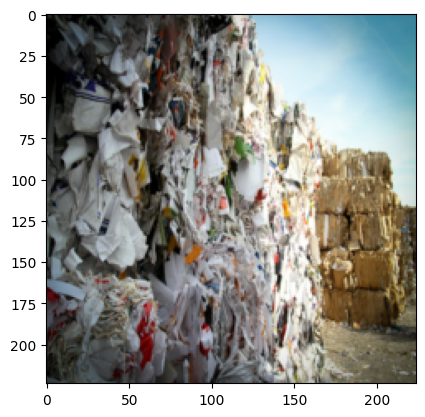

In [63]:
predict_random('RCP_illustration_1-scaled.jpg')

Predicted Class: plastic


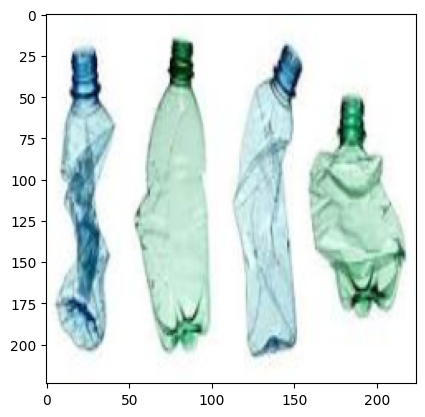

In [64]:
predict_random('plastics1.jpg')


Predicted Class: metal


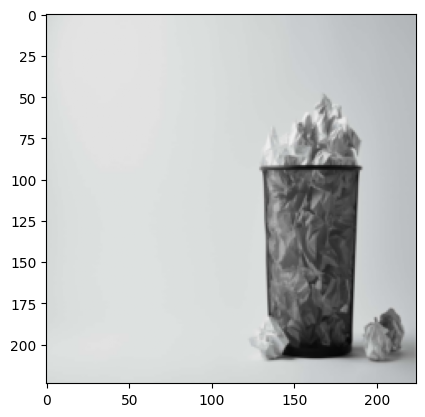

In [65]:
predict_random('Webp.net-resizeimage (12).jpg')


### Loading another model:

In [20]:
FILE = 'C:/Users/legen/Eco_Bins/garbage_classification/models/acc95/model2.pth'

import torch
from torchvision import transforms
from PIL import Image

# Load the image
image_path = "C:/Users/legen/Eco_Bins/garbage_classification/external/RCP_illustration_1-scaled.jpg"
image_name = image_path.split("/")[-1]
image = Image.open(image_path)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = torch.load(FILE, map_location=device)

# Define the transformations to be applied to the image
transform = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
])

# Apply the transformations to the image
input_tensor = transform(image).unsqueeze(0)

# Pass the image to the model to get the predicted class
with torch.no_grad():
    output = model(input_tensor.to(device))

# Convert the output to a probability distribution
probs = torch.softmax(output, dim=1)

# Get the predicted class
pred_class = torch.argmax(probs).item()

# Define the class names
class_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Print the predicted class and image name
print("The predicted class for the image", image_name, "is:", class_names[pred_class])
print(device)

The predicted class for the image RCP_illustration_1-scaled.jpg is: paper
cuda
